# Classification of the CIFAR-10 dataset

The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) provides 60000 32x32-pixel images, classified into 10 categories.  The figure below provides a random sample of some images in each category.

![images.png](images.png)

During this session, you will learn how to build a Convolutional Neural Network (CNN), which (when trained) will be able to automatically classify new images into one of these categories.  We will make use of the [Keras library](https://www.tensorflow.org/guide/keras) which provides a high-level interface to TensorFlow. Begin by importing the necessary modules.

In [24]:
from platform import python_version

print(python_version())

3.7.0


In [98]:
import os
import time
import datetime
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from keras.layers import Dense, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import normalize
from keras.models import load_model

# Table of content

[1. A first look at the data set](#dataset)<br>

[2. A first naive model](#first_model)<br>

[3. Convolutional Neural Networks](#cnn)<br>
- [3.1 Create your first CNN](#first_cnn)<br>
- [3.2 Influence of parameters on the performance](#cnn_parameters)<br>
- [3.3 Studying predictions](#results)<br>

[4. Pretrained Networks](#pretrained_cnn)<br>


<a id='dataset'></a>
# 1 - A first look at the data set

**1) Download the dataset. See [`keras.datasets`](https://keras.io/datasets/) for how to download the data.  Note that the dataset is already divided into a training set of 50000 images, and a test set of 10000.**

In [26]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

**2) Check the shape of images and targets.**

In [27]:
print(f"x_train shape is {x_train.shape}\nx_test shape is {x_test.shape}\n")
print(f"y_train shape is {y_train.shape}\ny_test shape is {y_test.shape}")

x_train shape is (50000, 32, 32, 3)
x_test shape is (10000, 32, 32, 3)

y_train shape is (50000, 1)
y_test shape is (10000, 1)


**3) Create a list of labels corresponding to the 10 categories.  This will be used to convert the 0-9 digits in the target arrays to string labels. The categories are labeled as follows**
  0. airplane
  1. automobile
  2. bird
  3. cat
  4. deer
  5. dog
  6. frog
  7. horse
  8. ship
  9. truck


In [28]:
labels = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

**4) Normalize images from [0,255] to be [0,1] (normalizing usually improves model training).**

To understand the data, these are the RGB values of the pixel in position (5,5) of the first image.

In [29]:
x_train_norm = x_train / 255

x_test_norm = x_test / 255

To understand the data, these are the RGB values of the pixel in position (5,5) of the first image.

In [30]:
x_train[0, 5, 5, :]

array([131,  84,  42], dtype=uint8)

Same pixel, after normalization.

In [31]:
x_train_norm[0, 5, 5, :]

array([0.51372549, 0.32941176, 0.16470588])

**5) Convert the target arrays to one-hot encodings.  Hint: checkout the [`keras.utils.to_categorical()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical)**

In [32]:
y_train = to_categorical(
    y_train, 
    num_classes=len(labels)
)

y_test = to_categorical(
    y_test, 
    num_classes=len(labels)
) 

**6) Visualize some images in each category using the `imshow()` function in `matplotlib.pyplot`.  Can you recreate the figure at the top?  Hint: the top figure was created using the first 8 images belonging to each category in the training data.**

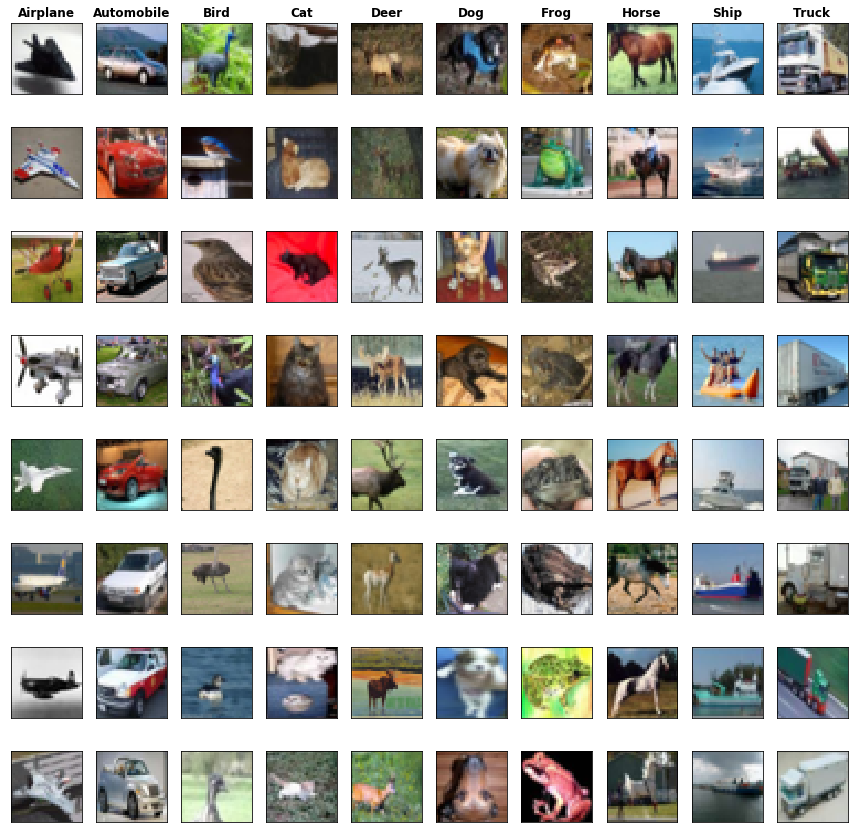

In [33]:
limit = 80
i = 1
count = 0
columns = len(labels)
rows = 8
num_cat = np.repeat(0, columns)

fig=plt.figure(figsize=(15, 15))


while count < limit:
    index_image = i - 1
    category, = np.where(y_train[index_image] == 1.)[0]
    if num_cat[category] < 8:
        location = columns * num_cat[category] + category + 1
        sp = fig.add_subplot(rows, columns, location, xticks= [], yticks=[])
        if(num_cat[category] == 0):
            sp.set_title(labels[category].title(),fontweight="bold")
        num_cat[category] = num_cat[category] + 1
        plt.imshow(x_train[index_image, :])
        count += 1
    i += 1

The following code summarizes the previous operations. 

In [35]:
def load_cifar_data():
    """
    Loads the CIFAR-10 dataset using Keras and preprocess for training.
    """
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    labels = {
        0: 'airplane',
        1: 'automobile',
        2: 'bird',
        3: 'cat',
        4: 'deer',
        5: 'dog',
        6: 'frog',
        7: 'horse',
        8: 'ship',
        9: 'truck'
    }

    x_train_norm = x_train / 255
    x_test_norm = x_test / 255
    
    y_train = to_categorical(y_train, num_classes=len(labels), dtype=int)
    y_test  = to_categorical(y_test, num_classes=len(labels), dtype=int)

    return x_train_norm, y_train, x_test_norm, y_test, labels

In [36]:
x_train_norm, y_train, x_test_norm, y_test, labels = load_cifar_data()

In [37]:
def show_first_n_images_in_categories(n, images, categories, labels, file_name=None):
    """Plots the first n images in each category from the image data."""
    
    fig, axs = plt.subplots(n, len(labels))
    fig.set_figheight(15)
    fig.set_figwidth(15)
#     plt.subplots_adjust(wspace=0.5, hspace=10)
    
    for j in labels.keys():
        imgs = images[categories[:,j]==1][:n]
        for i in range(n):
            axs[i,j].imshow(imgs[i])
            axs[i,j].set_xticks([])
            axs[i,j].set_yticks([])
    
    for ax, col in zip(axs[0], labels.values()):
        ax.set_title(col.title(), fontweight="bold")
    #fig
    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

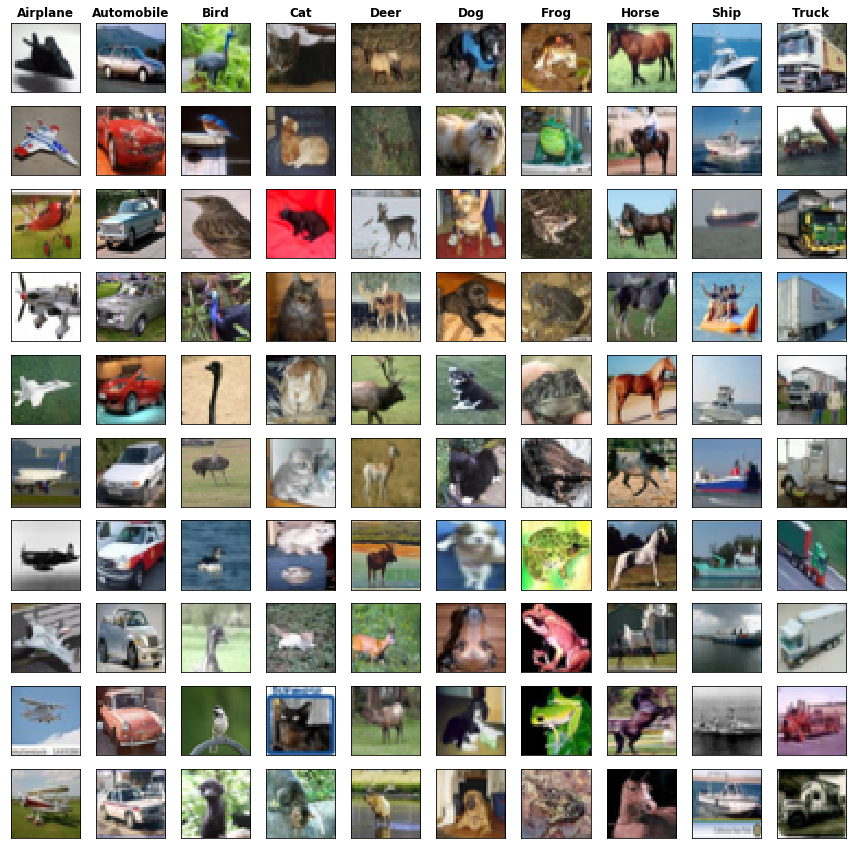

In [15]:
show_first_n_images_in_categories(10, x_train, y_train, labels, file_name = None)

<a id='first_model'></a>

# 2 - First naive model

In order to better understand the importance of CNNs, it is instructive to first see how well a naive dense network performs on the dataset.

**7) Create a sequential model with 4 `Dense` hidden layers of 2048, 1024, 512, and 256 nodes each, with ReLU activation, and a linear output layer of 10 nodes. Compile the model with a `categorical_crossentropy` loss, using the SGD optimizer, including the `accuracy` metric. 
Note that you will need to use the `Flatten` layer first in order to convert the 3D (x, y, rgb) image data into 1D.**

In [56]:
def dense_model(input_shape, num_classes):
    
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(2048, activation='relu'),
        Dense(1024, activation='relu'),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='sgd',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [57]:
model = dense_model(x_train.shape[1:], len(labels))
model.build()

**8) Compute by hand the total number of trainable parameters (weights and biases) in the model.**

The dimension of the flattened data is `32 x 32 x 3 = 3072` 

Then, the numbers of parameters for the first layer is : `(3072 + 1) x 2048 = 6293504`

For the second layer, we have `(2048 + 1) x 1024 = 2098176` parameters.

For the third layer, we have `(1024 + 1) x 512 = 524800` parameters.

For the fourth layer, we have `(512 + 1) x 256 = 131328` parameters.

For the fifth layer, we have `(256 + 1) x 10 = 2570` parameters.

If we sum all the parameters, we obtain a total of `6293504 + 2098176 + 524800 + 131328 + 2570 = 9050378` parameters.

**9) Use the `summary()` function on model to get a text summary of the model.  Did you compute the number of parameters correctly?**

In [40]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              6293504   
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 10)                2570      
Total params: 9,050,378
Trainable params: 9,050,378
Non-trainable params: 0
____________________________________________

**10) Train the model for 10 epochs, with a batch size of 32 (you may also use early stopping). What is the model performance?**

In [54]:
def train_model(model, x, y, batch_size=32, epochs=10, file_name=None, verbose=1):
    """
    Trains the model on the given data.
    """
    cb = [EarlyStopping(monitor='accuracy', patience=2)]
    history = model.fit(
        x,
        y, 
        batch_size=batch_size, 
        epochs=epochs, 
        callbacks=cb, 
        validation_split=0.2,
        verbose=verbose
    )
    return model, history

In [55]:
dense_mod, dense_hist = train_model(model, x_train_norm, y_train)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
 2912/40000 [=>............................] - ETA: 1:16 - loss: 2.1649 - accuracy: 0.1995

KeyboardInterrupt: 

**11) Plot several images with their predictions. Any comment?**

In [22]:
dense_mod = load_model('./naive_model')

In [23]:
pred = dense_mod.predict_classes(x_test_norm)

Our model assigns all images to the same label. Indeed, the number of parmeters is very large so we tend to overfit on the data and one class dominates all the others.

In [24]:
np.bincount(pred, minlength=10)

array([    0,     0,     0,     0,     0,     0, 10000,     0,     0,
           0])

In [90]:
def plot_n_first_pred(pred, n=20):
    col_legend = ['red', 'green']
    fig=plt.figure(figsize=(n, n))
    for i in range(n):
        row_number = n//4 if n//4>0 else 1 # check needed in case n<4
        sp = fig.add_subplot(row_number, np.ceil(n/row_number), i+1, xticks=[], yticks=[])
        cond = int(pred[i] == y_test[i].argmax())
        col = col_legend[cond]
        sp.set_title(labels[pred[i]].title(),fontweight="bold", color=col)
        plt.imshow(x_test[i, :], )

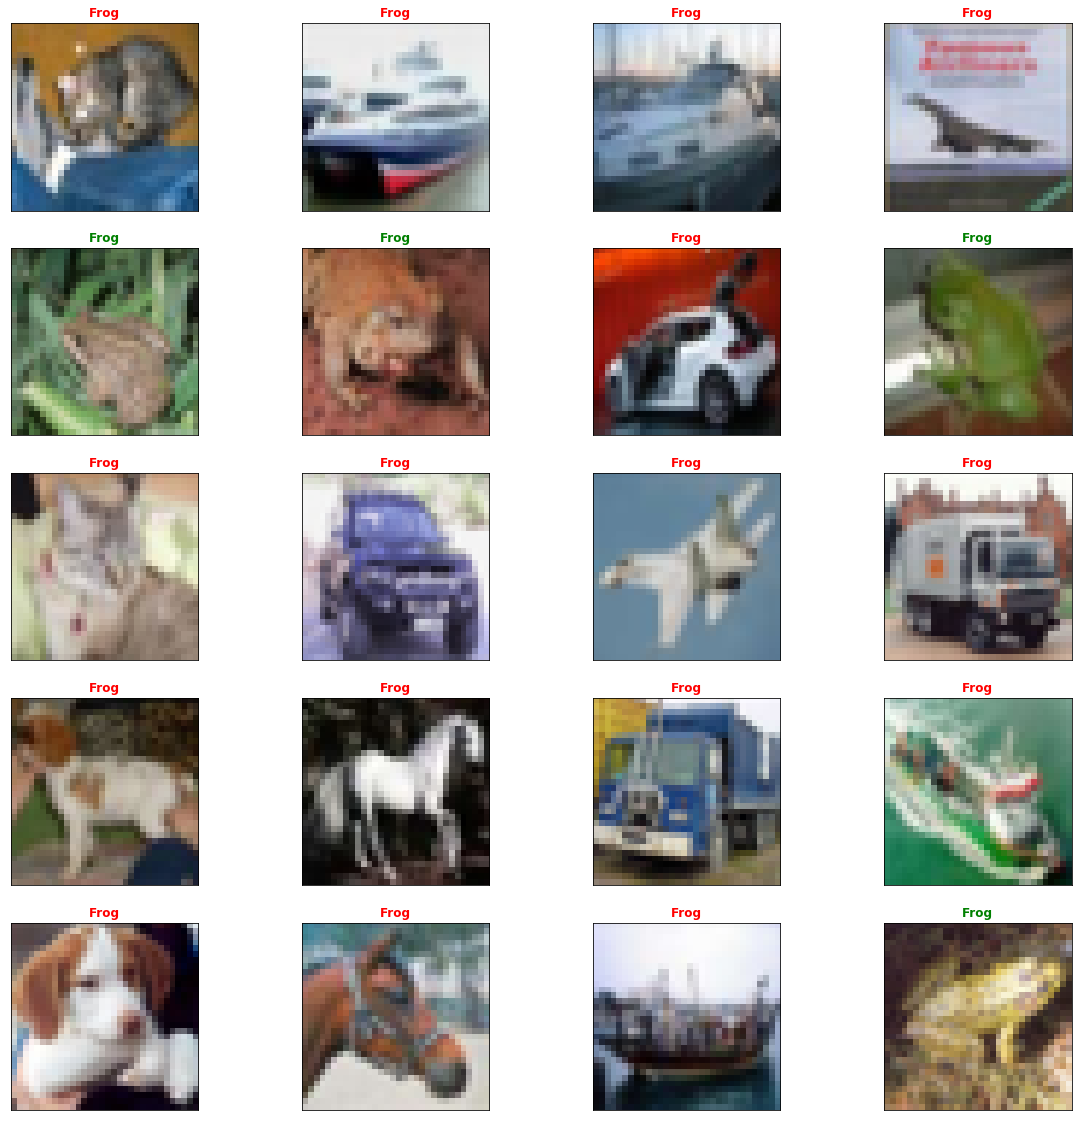

In [26]:
plot_n_first_pred(pred, 20)

<a id='cnn'></a>

# 3 - Convolutional Neural Network
 

Convolutional neural networks allow us to do drastically better on this dataset (and many image classification problems in general).  In this task, you will build your first convolutional network and see how it performs during training.

<a id='first_cnn'></a>
## 3.1 - Create your first CNN

**12) Create a new model with the following layers (use the same optimizer and loss as above)**
  - 3x3 2D convolution with zero padding (same), 32 filters
  - ReLU activation
  - 3,3 2D convolution, no padding, 32 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - 3x3 2D convolution, no padding, 64 filters
  - ReLU activation
  - Max pooling with size (2,2)
  - Flatten
  - Dense layer with 512 nodes, ReLU activation
  - Softmax output layer with 10 nodes

In [58]:
def cnn_model(input_shape, num_classes):
    
    model = Sequential([
            Conv2D(
                filters=32,
                kernel_size=3, 
                padding='same',
                activation='relu',
                input_shape=input_shape
            ),
            Conv2D(
                filters=32,
                kernel_size=3, 
                padding='valid',
                activation='relu'
                ),
            MaxPooling2D(2),
            Conv2D(
                filters=64,
                kernel_size=3, 
                padding='valid',
                activation='relu'
            ),
            Conv2D(
                filters=64,
                kernel_size=3, 
                padding='valid',
                activation='relu'
            ),       
            MaxPooling2D(2),
            Flatten(),
            Dense(512, activation='relu'),
            Dense(10, activation='softmax')
        ])
    
    model.compile(
        optimizer='sgd',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )    
    
    return model

In [59]:
cnn_mod = cnn_model(x_train.shape[1:], 10)

**13) Compute by hand the number of trainable parameters in this network.  Are there more or less than the more simple dense network?  Why?  Confirm with `summary()`.**

For every convolutional layer, the number of parameters is equal to :

`(number of channels (3) x dimension of the kernel + biais (1)) x number of feature maps)`

The number of parameters thus is :

- 1st convolutional layer : `(3 x 9 + 1) x 32 = 896` parameters.
- 2nd convolutional layer : `(32 x 9 + 1) x 32 = 9248` parameters.
- 1st pooling layer `0` parameters. (makes the output `15 x 15`)
- 3rd convolutional layer : `(32 x 9 + 1) x 64 = 18496` parameters.
- 4th convolutional layer : `(64 x 9 + 1) x 64 = 36928` parameters.
- 2nd pooling layer `0` parameters. (makes the output `5 x 5`)
- 1st flatten layer `0` parameters. (flattens `64 x 5 x 5` to `1600 x 1`)
- 1st dense layer `(1600 + 1) x 512 = 819712` parameters.
- 1st dense layer `(512 + 1) x 10 = 5130` parameters.

The total number of parameters is then :
`896 + 9248 + 18496 + 36928 + 819712 + 5130 = 890410` parameters in total.

There are fewer parameters than the simple dense network because we **progressively reduce the size** of the input by using **convolution** and **pooling**.

In [60]:
cnn_mod.build()
cnn_mod.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1600)             

**14) Train the network for 10 epochs, with batch size of 32. How does the validation accuracy change with each epoch?**

In [61]:
cnn_mod, hist = train_model(cnn_mod, x_train_norm[:5000, :], y_train[:5000])

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 7s 2ms/step - loss: 2.2930 - accuracy: 0.1350 - val_loss: 2.2763 - val_accuracy: 0.1770
Epoch 2/10
4000/4000 [==============================] - 7s 2ms/step - loss: 2.2267 - accuracy: 0.1978 - val_loss: 2.1370 - val_accuracy: 0.2420
Epoch 3/10
4000/4000 [==============================] - 7s 2ms/step - loss: 2.0937 - accuracy: 0.2245 - val_loss: 2.0257 - val_accuracy: 0.2630
Epoch 4/10
4000/4000 [==============================] - 6s 2ms/step - loss: 2.0000 - accuracy: 0.2805 - val_loss: 1.9883 - val_accuracy: 0.2580
Epoch 5/10
4000/4000 [==============================] - 7s 2ms/step - loss: 1.9576 - accuracy: 0.2920 - val_loss: 1.9790 - val_accuracy: 0.2850
Epoch 6/10
4000/4000 [==============================] - 7s 2ms/step - loss: 1.9192 - accuracy: 0.3072 - val_loss: 1.9400 - val_accuracy: 0.3040
Epoch 7/10
4000/4000 [==============================] - 6s 2ms/step - loss: 1.8817 - acc

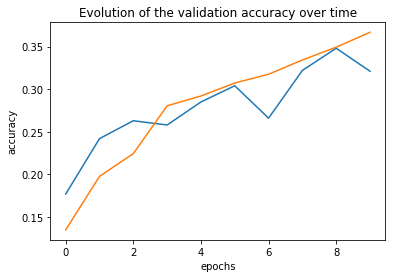

In [62]:
plt.plot(hist.history['val_accuracy'], label = 'Validation accuracy')
plt.plot(hist.history['accuracy'], label = 'Training accuracy')

plt.title('Evolution of the validation accuracy over time')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

<a id='cnn_parameters'></a>
## 3.2 - Influence of parameters on the performance

**15) How does the performance depend on batch size?**

The first 5000 observations are pretty balanced. Therefore, for computational reasons, we will evaluate the performance on a smaller dataset.

In [63]:
np.bincount(y_train[:5000].argmax(-1))

array([505, 460, 519, 486, 519, 488, 519, 486, 520, 498])

Batch size : 8
Batch size : 32
Batch size : 128
Batch size : 512


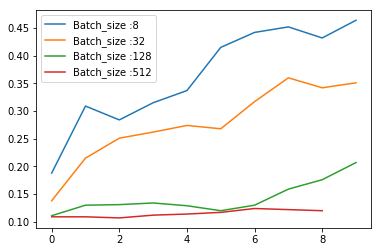

In [64]:
batch_sizes = [8, 32, 128, 512]
for bs in batch_sizes:
    cnn_mod = cnn_model(x_train.shape[1:], 10)
    print('Batch size : ' + str(bs))
    mod, hist = train_model(
        cnn_mod,
        x_train_norm[:5000, :], 
        y_train[:5000], 
        batch_size=bs,
        verbose=0
    )
    plt.plot(hist.history['val_accuracy'],label='Batch_size :' + str(bs))
plt.legend()
plt.show()

We can see that **the smaller the batch size, the better the accuracy**. We can explain this by the lack of generalization of large batch models, as explained in the following [Stack Overflow post](https://stats.stackexchange.com/questions/164876/tradeoff-batch-size-vs-number-of-iterations-to-train-a-neural-network), qouted below :

> From Nitish Shirish Keskar, Dheevatsa Mudigere, Jorge Nocedal, Mikhail Smelyanskiy, Ping Tak Peter Tang. On Large-Batch Training for Deep Learning: Generalization Gap and Sharp Minima. https://arxiv.org/abs/1609.04836 :
>
>"It has been observed in practice that when using a larger batch there is a significant degradation in the quality of the model, as measured by its ability to generalize. In this paper, we present ample numerical evidence that supports the view that large-batch methods tend to converge to sharp minimizers of the training and testing functions -- and that sharp minima lead to poorer generalization. In contrast, small-batch methods consistently converge to flat minimizers, and our experiments support a commonly held view that this is due to the inherent noise in the gradient estimation." 
>
>[…]
>
>"The lack of generalization ability is due to the fact that large-batch methods tend to converge to sharp minimizers of the training function. These minimizers are characterized by large positive eigenvalues in H(x) and tend to generalize less well. In contrast, small-batch methods converge to flat minimizers characterized by small positive eigenvalues of H(x). We have observed that the loss function landscape of deep neural networks is such that large-batch methods are almost invariably attracted to regions with sharp minima and that, unlike small batch methods, are unable to escape basins of these minimizers."

**16) Note how the validation accuracy begins to decrease at some point, while the training accuracy continues to increase.  What is this phenomenon?  Try adding 3 dropout layers to the model, one before each max pooling layer and one before the last layer, using a dropout ratio of 0.25.  Does this improve the model? How does the performance vary with the dropout ratio?**

The phenomenon is due to overfitting. Our model is putting too much emphasis on the training set, resulting in failing to generalize and accurately predicting examples in the test set.

The code below allows us to answer to both question 16 and 17, by specifying the parameters *dropout* and *batch_norm*.

In [65]:
def cnn_model(input_shape, num_classes, dropout=False, rate=0.25, batch_norm=False):
    
    model = Sequential()
    model.add(Conv2D(
        filters=32,
        kernel_size=3, 
        padding='same',
        activation='relu',
        input_shape=input_shape,
        name = 'Conv1'
    ))
    model.add(Conv2D(
        filters=32,
        kernel_size=3,
        padding='valid',
        activation='relu',
        name = 'Conv2'
    ))
    if batch_norm:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate=rate))
    model.add(MaxPooling2D(name = 'MaxPool1'))
    model.add(Conv2D(
        filters=64,
        kernel_size=3,
        padding='valid',
        activation='relu',
        name = 'Conv3'
    ))
    model.add(Conv2D(
        filters=64,
        kernel_size=3,
        padding='valid',
        activation='relu',
        name = 'Conv4'
    ))
    if batch_norm:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate=rate))
    model.add(MaxPooling2D(name='MaxPool2'))
    model.add(Flatten(name='Flatten'))
    model.add(Dense(512, activation='relu', name = 'Dense1'))
    if batch_norm:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate=rate))
    model.add(Dense(num_classes, activation='softmax', name='Dense2'))
    
    model.compile(
        optimizer='sgd',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

Let's now study how the performance vary with the dropout ratio:

Dropout rate : 0.2
Dropout rate : 0.25
Dropout rate : 0.3
Dropout rate : 0.4


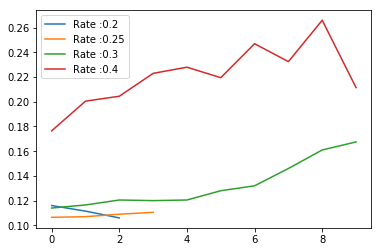

In [66]:
rates = [0.2, 0.25, 0.3, 0.4]
for rate in rates:
    cnn_dr = cnn_model(x_train.shape[1:], 10, dropout=True, rate=rate)
    print('Dropout rate : ' + str(rate))
    mod, hist = train_model(
        cnn_mod,
        x_train_norm[:10000, :], 
        y_train[:10000], 
        batch_size=bs,
        verbose=0
    )
    plt.plot(hist.history['val_accuracy'],label='Rate :' + str(rate))
plt.legend()
plt.show()

A rate of 0.3 seems to be a good solution. Below, a model is trained on more data.

In [67]:
model = cnn_model(x_train.shape[1:], 10, dropout=True, rate=0.25)
model.build()
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
dropout_19 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 15, 15, 32)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 13, 13, 64)        18496     
_________________________________________________________________
Conv4 (Conv2D)               (None, 11, 11, 64)        36928     
_________________________________________________________________
dropout_20 (Dropout)         (None, 11, 11, 64)      

In [68]:
cnn_dropout = train_model(model, x_train_norm, y_train)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 76s 2ms/step - loss: 2.0059 - accuracy: 0.2665 - val_loss: 1.8831 - val_accuracy: 0.3610
Epoch 2/10
40000/40000 [==============================] - 75s 2ms/step - loss: 1.6838 - accuracy: 0.3907 - val_loss: 1.6491 - val_accuracy: 0.4375
Epoch 3/10
40000/40000 [==============================] - 77s 2ms/step - loss: 1.5146 - accuracy: 0.4507 - val_loss: 1.5176 - val_accuracy: 0.4911
Epoch 4/10
40000/40000 [==============================] - 94s 2ms/step - loss: 1.3939 - accuracy: 0.4961 - val_loss: 1.4106 - val_accuracy: 0.5363
Epoch 5/10
40000/40000 [==============================] - 114s 3ms/step - loss: 1.2968 - accuracy: 0.5375 - val_loss: 1.3382 - val_accuracy: 0.5671
Epoch 6/10
40000/40000 [==============================] - 111s 3ms/step - loss: 1.2168 - accuracy: 0.5688 - val_loss: 1.2773 - val_accuracy: 0.5943
Epoch 7/10
40000/40000 [==============================] - 112s 3ms

Adding dropout layers slightly increases the validation accuracy, while at the same time it decreases the train accuracy. 

**17) Add batch normalization layers before each dropout layer. What is their impact on the model's performance?**

In [69]:
model_batchnorm = cnn_model(x_train.shape[1:], 10, dropout=True, rate=0.25, batch_norm=True)
model_batchnorm.build()
model_batchnorm.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Conv2 (Conv2D)               (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
dropout_22 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
MaxPool1 (MaxPooling2D)      (None, 15, 15, 32)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 13, 13, 64)        18496     
_________________________________________________________________
Conv4 (Conv2D)               (None, 11, 11, 64)      

In [70]:
model_batchnorm, batchnorm_hist = train_model(model_batchnorm, x_train_norm, y_train)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 94s 2ms/step - loss: 1.8114 - accuracy: 0.3817 - val_loss: 2.1641 - val_accuracy: 0.3425
Epoch 2/10
40000/40000 [==============================] - 88s 2ms/step - loss: 1.3694 - accuracy: 0.5161 - val_loss: 2.4100 - val_accuracy: 0.3290
Epoch 3/10
40000/40000 [==============================] - 115s 3ms/step - loss: 1.2108 - accuracy: 0.5731 - val_loss: 1.6835 - val_accuracy: 0.4433
Epoch 4/10
40000/40000 [==============================] - 105s 3ms/step - loss: 1.0997 - accuracy: 0.6124 - val_loss: 1.2225 - val_accuracy: 0.5667
Epoch 5/10
40000/40000 [==============================] - 137s 3ms/step - loss: 1.0207 - accuracy: 0.6413 - val_loss: 1.1667 - val_accuracy: 0.5920
Epoch 6/10
40000/40000 [==============================] - 142s 4ms/step - loss: 0.9440 - accuracy: 0.6687 - val_loss: 1.1864 - val_accuracy: 0.6015
Epoch 7/10
40000/40000 [==============================] - 100s 2

In [71]:
model_batchnorm.save('./model_batchnorm')

Adding a batch normalization layer before each dropout layer, results in a model which is highly overfitting the training data. The validation accuracy, despite being lower than before, is also oscillating between 0.18 and 0.35.

The model is then very sensitivity to noise and results in describing random error. instead of the underlying relationships.

<a id='results'></a>

## 3.3 - Studying predictions

Assuming all went well during the previous tasks, you can now predict the category of a new image!  Here are a few examples of my predictions:

![predictions.png](predictions.png)

**18) Use `predict` on your trained model to test its prediction on a few example images of the test set. Using `imshow` and `hbar` from `matplotlib.pyplot`, try to recreate the image above for a few example images.**

**Hint:** at this point, it is probably convenient to use the `save` and `load_model` functions from Keras.  You can save the model after training it, and then decide to load from saved file instead of building a new one (if available) on successive runs.

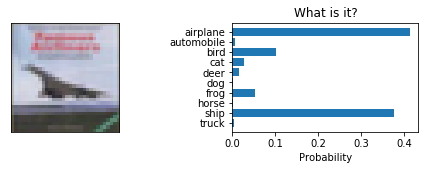

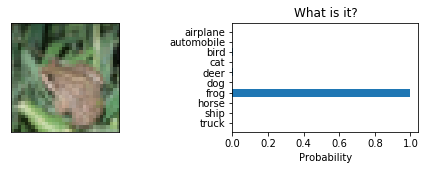

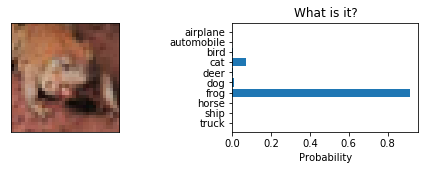

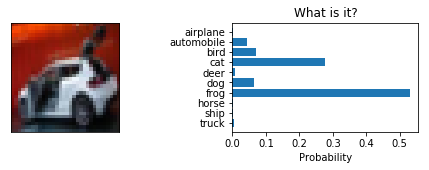

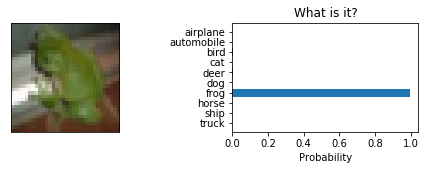

In [75]:
def predict(model, x, labels, file_name=None):
    
    pred = model.predict(x)
    for i in range(len(pred)):
        
        fig, (ax1, ax2) = plt.subplots(1,2)
        fig.set_figheight(len(x)//2)
        fig.set_figwidth(8)
        plt.subplots_adjust(wspace=0.4, hspace=10)
        
        ax1.imshow(x[i,:,:,:])
        ax1.set_xticks([])
        ax1.set_yticks([])
    
        
        y_pos = np.arange(len(labels))
        ax2.barh(y_pos, pred[i], align='center')
        ax2.set_yticks(y_pos)
        ax2.set_yticklabels(labels.values())
        ax2.invert_yaxis()
        ax2.set_xlabel('Probability')
        ax2.set_title('What is it?')
    
    
    if file_name:
        plt.savefig(file_name)
    else:
        plt.show()

# predict(cnn_dropout, x_test[3:8,:,:,:], labels, file_name="predictions.png")

predict(model_batchnorm, x_test_norm[3:8,:,:,:], labels)

Let's have a look at how the model_batchnorm predicts.

It looks like there are troubles classifying automobiles.

In [80]:
score, acc = model_batchnorm.evaluate(
    x_test_norm,
    y_test
)
print('Test score:', score)
print('Test accuracy:', acc)

10000/10000 [==============================] - 4s 432us/step
Test score: 1.7188485193252563
Test accuracy: 0.5037999749183655


Our batchnorm model seems to favor a bit the class 6 (Frog).

In [95]:
batchnorm_pred = model_batchnorm.predict_classes(x_test_norm)

In [93]:
np.bincount(batchnorm_pred)

array([ 483,  569, 1772, 1048, 1341,  429, 2960,  346,  753,  299])

Given how the test set is perfectly balanced:

In [86]:
np.bincount(y_test.argmax(-1))

array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])

and so is the training set:

In [87]:
np.bincount(y_train.argmax(-1))

array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000])

The graph below confirms our thesis:

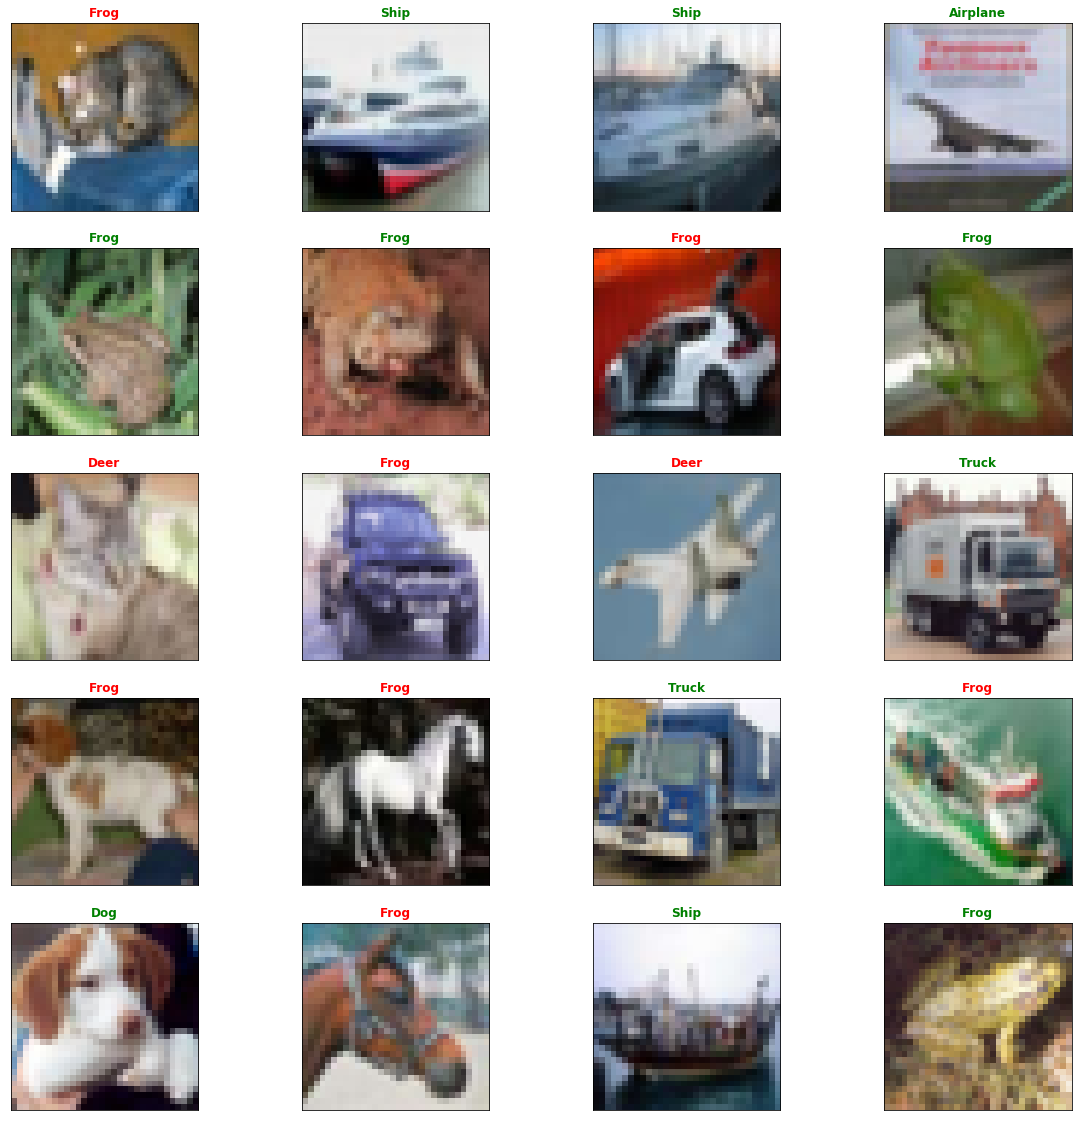

In [94]:
plot_n_first_pred(batchnorm_pred)

---

A confusion matrix is often used in supervised learning to understand how well (or not) each category is being classified.  Each element (i,j) in the confusion matrix represents the predicted class j for each true class i.  Consider the following 10 predictions for a 2 category model predicting male or female.

| example     | true category  | predicted category  |
|-------------|----------------|---------------------|
| 1           | male           | male                |
| 2           | female         | male                |
| 3           | female         | female              |
| 4           | male           | male                |
| 5           | male           | female              |
| 6           | male           | male                |
| 7           | female         | female              |
| 8           | male           | female              |
| 9           | female         | female              |
| 10          | female         | female              |

Based on the above data, the model is accurate 70% of the time.  The confusion matrix is

|        | predicted male | predicted female |
|--------|------|--------|
| true male   | 3    | 2      |
| true female | 1    | 4      |

The confusion matrix gives us more information than a simple accuracy measurement. 

**19) Create the confusion matrix the CIFAR-10 dataset using the test data.  What does it tell you about the relationships between each class?**

In [96]:
cnn_batchnorm = load_model('./model_batchnorm')

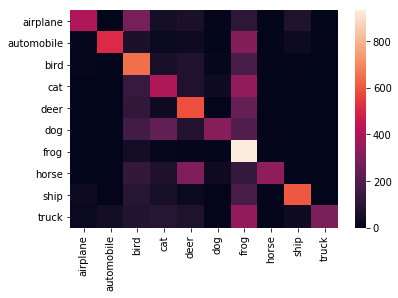

In [99]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    conf_mat = confusion_matrix(y_true.argmax(axis=-1), y_pred)
    cm_df = pd.DataFrame(
        conf_mat,
        index = classes,
        columns= classes
    )
    sn.heatmap(cm_df)

plot_confusion_matrix(y_test, batchnorm_pred, list(labels.values()))

<a id='pretrained_cnn'></a>
# 4 - Pretrained Networks (Bonus !)

Note that several pre-trained networks are directly accessible via keras (see https://nbviewer.jupyter.org/github/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb)

**20) Build a classifier with a better accuracy on the test set than all CNN you have built before. One rule only: do not use CNN pretrained on CIFAR10.** 

In [10]:
from keras.models import load_model

In [11]:
from keras.applications.resnet50 import ResNet50, decode_predictions
import tensorflow as tf

In [12]:
model = ResNet50(weights='imagenet')

In [26]:
x_train_resized = tf.image.resize(x_train[:5000, :], [224,224]).numpy()

In [30]:
y_proba = model.predict(x_train_resized[:10,:])

In [31]:
top_K = decode_predictions(y_proba, top=3)
for image_index in range(10):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("    {}   - {:12s} {:.2f}%".format(class_id, name, y_proba *100))

Image #0
    n04286575   - spotlight    23.82%
    n03929660   - pick         12.96%
    n03825788   - nipple       10.75%
Image #1
    n03796401   - moving_van   71.63%
    n04266014   - space_shuttle 4.29%
    n03000247   - chain_mail   1.52%
Image #2
    n04428191   - thresher     53.53%
    n03000684   - chain_saw    6.49%
    n03804744   - nail         5.19%
Image #3
    n02074367   - dugong       12.87%
    n01930112   - nematode     5.73%
    n01990800   - isopod       4.14%
Image #4
    n04456115   - torch        45.78%
    n03764736   - milk_can     15.77%
    n02783161   - ballpoint    12.31%
Image #5
    n04579145   - whiskey_jug  14.19%
    n04127249   - safety_pin   7.82%
    n03720891   - maraca       6.19%
Image #6
    n02013706   - limpkin      25.68%
    n02090379   - redbone      7.67%
    n02074367   - dugong       6.07%
Image #7
    n02415577   - bighorn      20.55%
    n02389026   - sorrel       11.44%
    n02395406   - hog          10.57%
Image #8
    n02783161   

In [18]:
###########################
# TO DO 

# END TO DO 
##################

In [19]:
###########################
# TO DO 

# END TO DO 
##################

In [20]:
###########################
# TO DO 

# END TO DO 
##################

In [21]:
##################
# TO DO 


# END TO DO 
##################